# One Single Model Prediction

## Section 1: Data Preparation

### Import packages

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# models necessary to define the forecasting models 
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from forecast_combine.forecast import Forecast

/home/ubuntu/Documents/Projects/forecast/forecast_combine/forecast.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
from warnings import simplefilter
simplefilter('ignore')

### Lire les donnees

In [4]:
np.random_state = 0
data = pd.Series(np.cumsum(np.random.normal(0, 1, size=1000)), 
                 index=pd.date_range(end='31/12/2022', periods=1000)).rename('y').to_frame()
data.head(2)

,y
2020-04-06,-0.385446
2020-04-07,-0.605125


<Axes: >

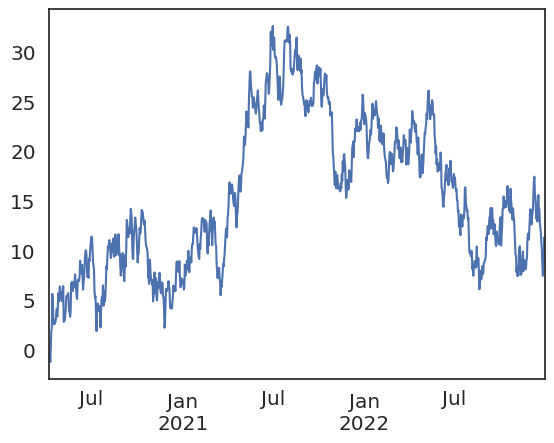

In [5]:
data.y.plot()

## Section 2: Model Definition

In [6]:
model = StatsForecastAutoARIMA(n_jobs = 4, trend=True, seasonal=True, max_p= 10, max_q=10)

In [7]:
LF = Forecast(data = data,
                          depvar_str='y',      
                          exog_l= None,
                          forecaster_name = 'AutoARIMA',
                          forecaster= model,
                          fh = 5,
                          pct_initial_window = 0.5,
                          step_length = 25, 
                          freq = 'B')

## Section 3: In-sample vs Out-Of-smaple

### Cross validation Procedure

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Insample vs Out-Of-Sample'}, ylabel='y'>)

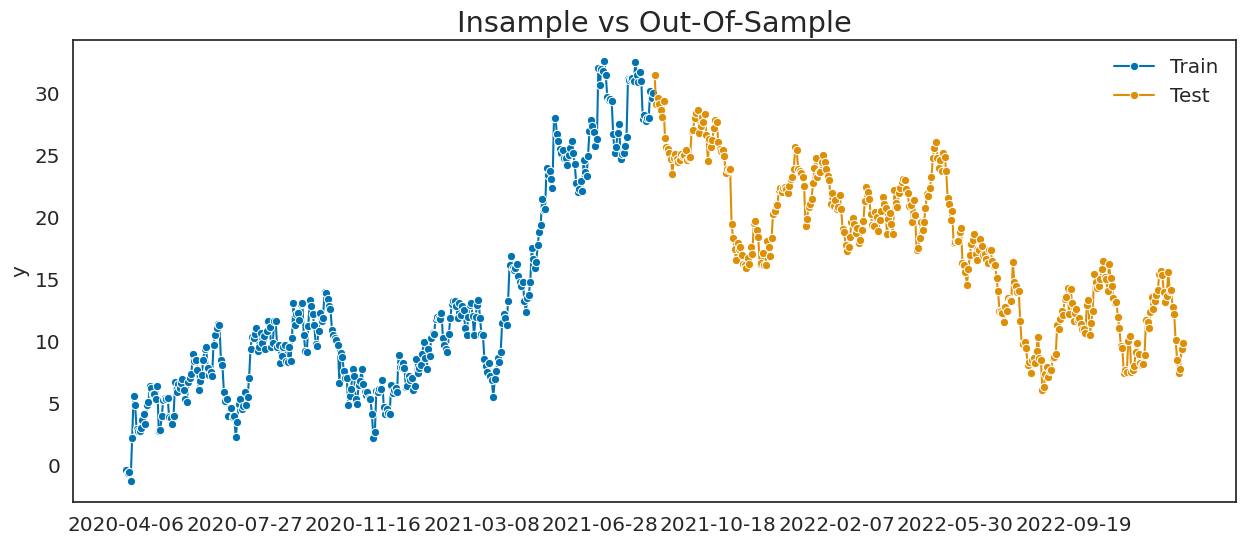

In [8]:
LF.plot.plot_train_test(
    labels = ['Train', 'Test'],
    title='Insample vs Out-Of-Sample')

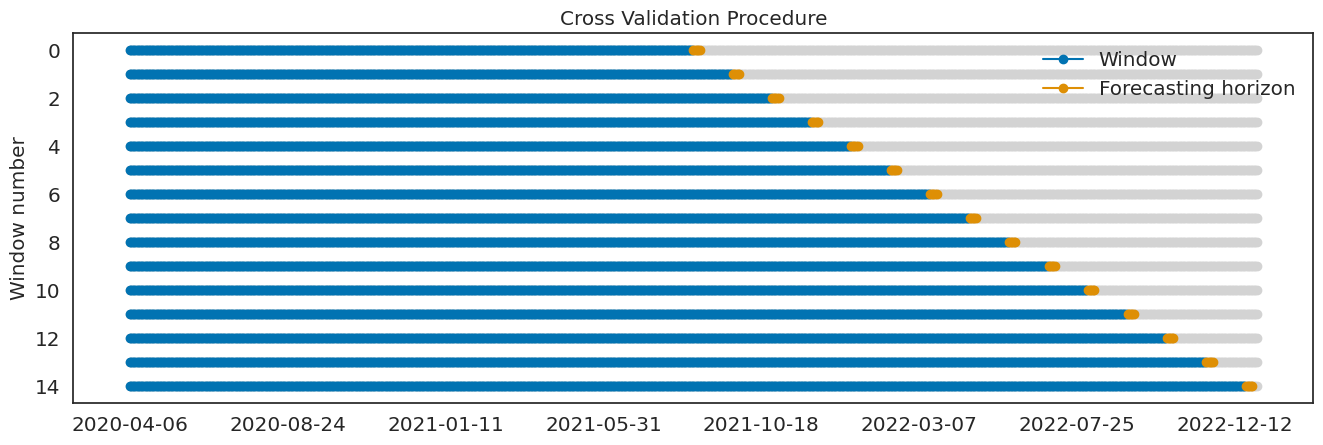

In [9]:
LF.plot.plot_cv_procedure(xlabel='')

### Fit

In [10]:
lf_fit= LF.fit(on='train')

### In Sample Evaluation

In [11]:
pred = lf_fit.insample_predictions(nsample =200)
display(pred.head())

200it [00:02, 77.15it/s]


,index,y_pred,y_true,Abs_diff,horizon,cutoff
0,2020-04-07,-0.385446,-0.605125,0.219678,1,2020-04-06
1,2020-04-08,-0.605125,-0.536421,0.068704,2,2020-04-06
2,2020-04-09,-0.536421,-1.254399,0.717978,3,2020-04-06
3,2020-04-10,-1.254399,2.192920,3.447319,4,2020-04-06
4,2020-04-13,2.192920,5.611196,3.418277,5,2020-04-06


In [12]:
insample_perf_summary = lf_fit.insample_perf()

In [13]:
insample_perf_summary['horizon']

,RMSE,MAPE
horizon,,
1,1.169991,0.100313
2,1.363638,0.113344
3,1.258674,0.099897
4,1.182607,0.108896
5,1.369747,0.105564


In [14]:
display(insample_perf_summary['cutoff'].head())
display(insample_perf_summary['horizon'].head())

,RMSE,MAPE
cutoff,,
2020-04-06,2.197139,0.648938
2020-04-08,2.381831,0.712495
2020-04-14,0.927422,0.202384
2020-04-15,0.387836,0.092001
2020-04-16,0.521561,0.129067


,RMSE,MAPE
horizon,,
1,1.169991,0.100313
2,1.363638,0.113344
3,1.258674,0.099897
4,1.182607,0.108896
5,1.369747,0.105564


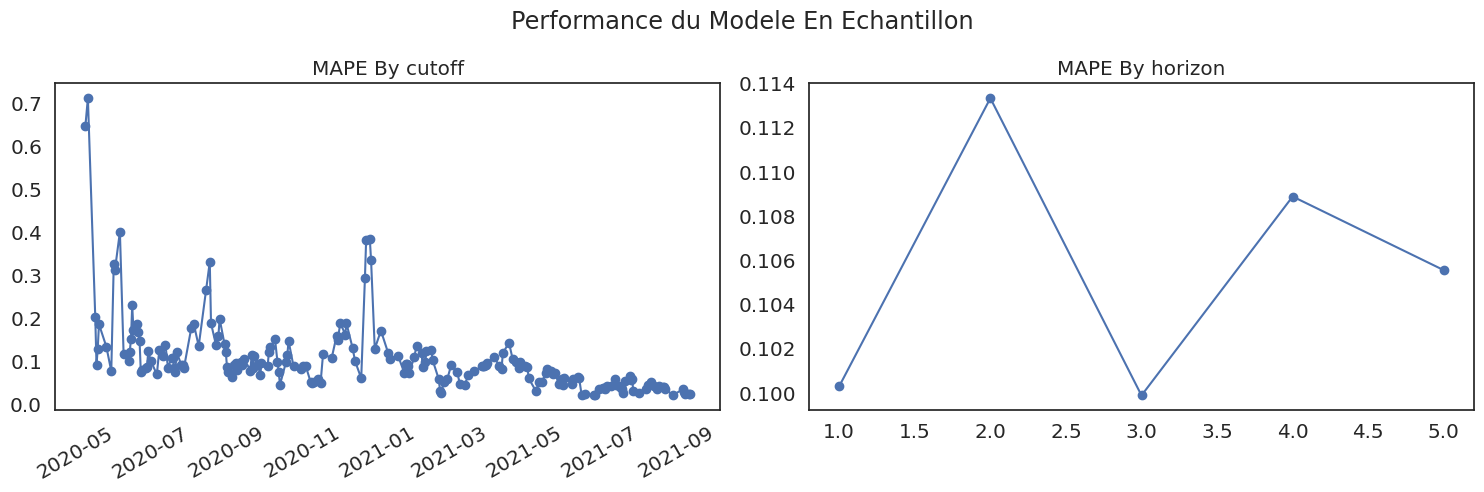

In [15]:
lf_fit.plot.plot_insample_performance(metric='MAPE', title = 'Performance du Modele En Echantillon')

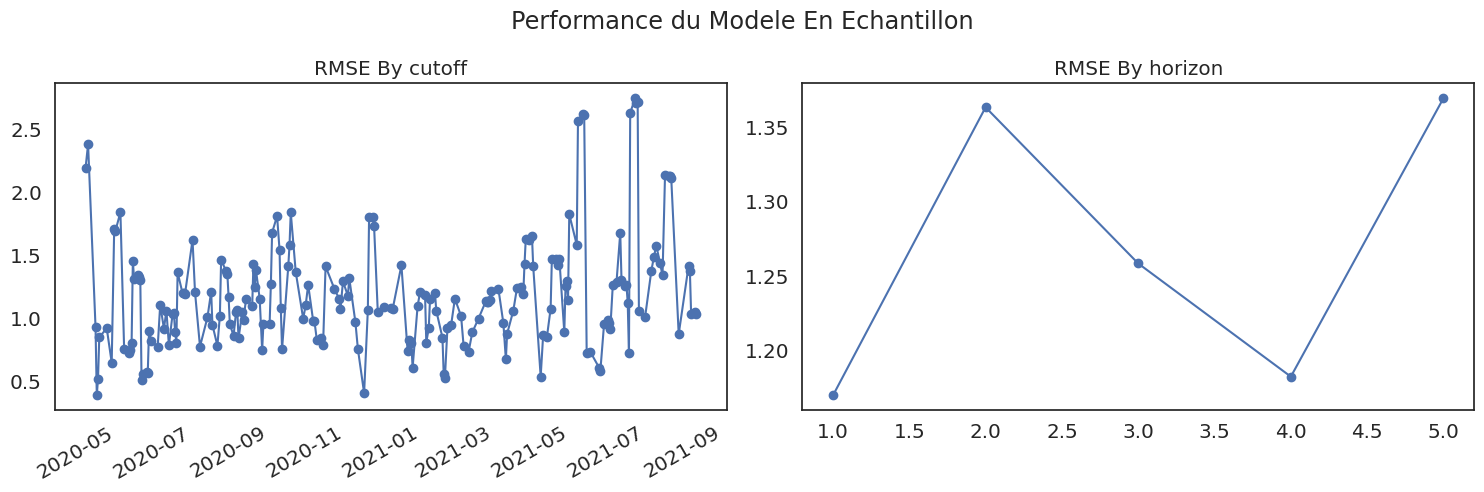

In [16]:
lf_fit.plot.plot_insample_performance(metric='RMSE', title = 'Performance du Modele En Echantillon')

### Out-Of-sample Evaluation

In [17]:
lf_eval= LF.evaluate()


Start forecaster AutoARIMA evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 0.05 minutes


In [18]:
lf_eval.summary_results()

,Number of Folds,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg MAPE,Avg RMSE
0,15,0.102905,0.084698,357,707,2021-08-17,2022-12-20,0.115073,2.001442


In [19]:
lf_eval.summary_horizon()

,RMSE,MAPE
horizon,,
1,1.035050,0.045779
2,1.188576,0.059974
3,2.501399,0.137294
4,2.802927,0.148304
5,3.144711,0.184012


<Axes: title={'center': 'Out of Sample Performance - Average on All Horizons'}, ylabel='MAPE'>

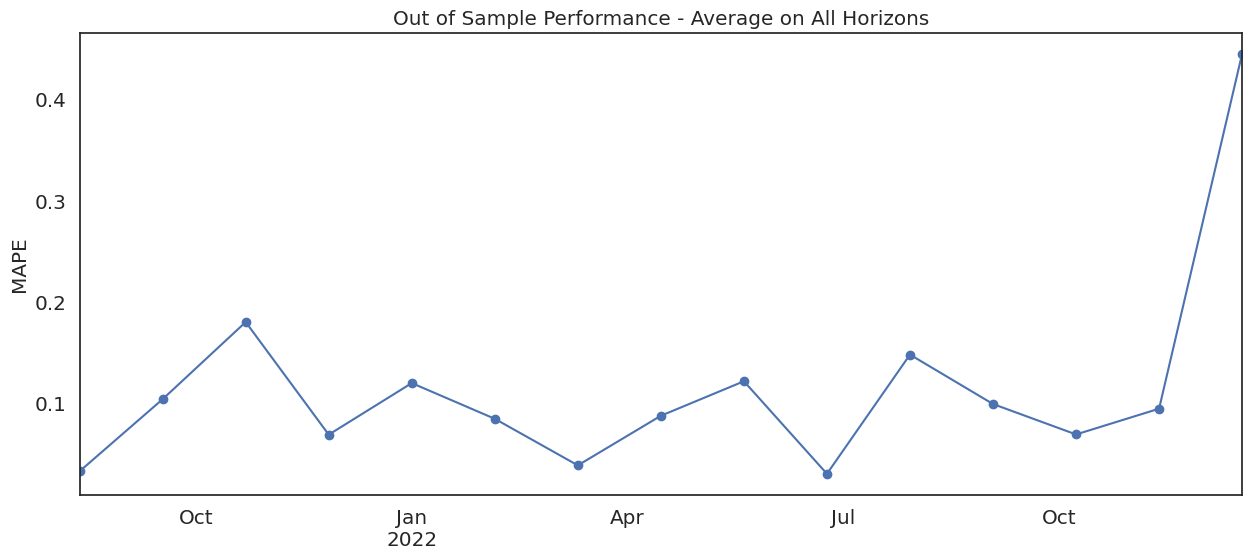

In [20]:
lf_eval.plot.plot_oos_score(score = 'MAPE')

<Axes: title={'center': 'Out of Sample Performance - Average per Horizons'}, xlabel='Horizon', ylabel='MAPE'>

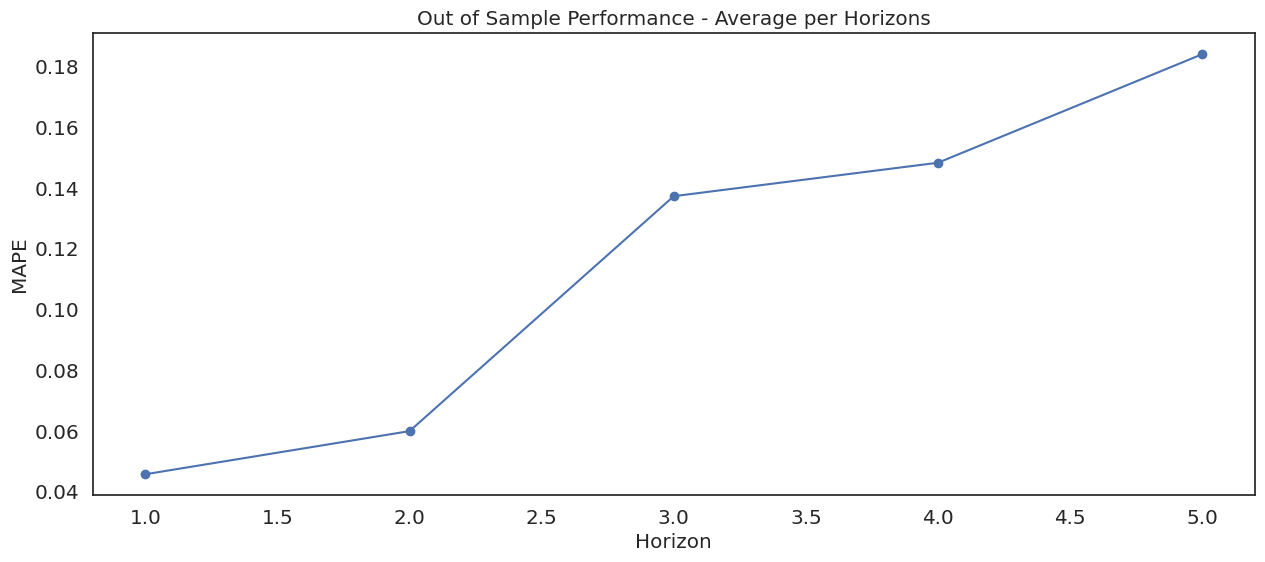

In [21]:
lf_eval.plot.plot_oos_horizon(score = 'MAPE', xlabel = 'Horizon')

## Section 4: Generate predictions

In [22]:
# First Fit on all the sample
LF.fit(on ='all')
# Predict
y_pred, y_pred_ints = LF.predict()

(<Figure size 1300x500 with 1 Axes>,
 <Axes: title={'center': 'ARIMA Prediction'}, ylabel='y'>)

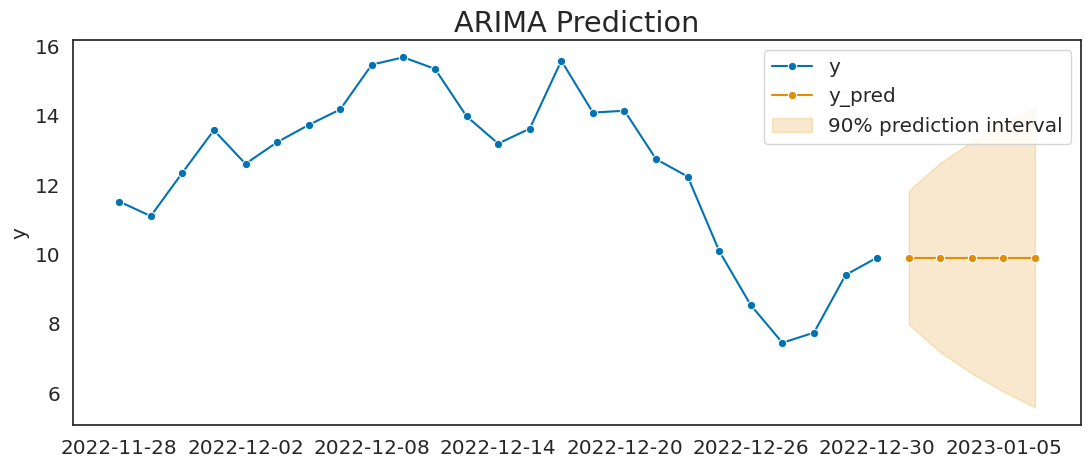

In [23]:
LF.plot.plot_prediction(y_pred, y_pred_ints, 
                        labels=['y', 'y_pred'], 
                        title = 'ARIMA Prediction', 
                        figsize = (13,5))

### Section 5: Update Predictions when new data comes in

In [24]:
# create a dataframe with the new data
newdata = pd.concat([data, 
                     pd.DataFrame(index=[y_pred.index[0]], columns =data.columns)
                    ])
newdata.loc[y_pred.index[0], 'BMC'] = y_pred.iloc[0]
newdata = newdata.ffill()
newdata.tail()

,y,BMC
2022-12-28,7.729697,NaN
2022-12-29,9.392083,NaN
2022-12-30,11.312329,NaN
2022-12-31,9.894676,NaN
2023-01-02,9.894676,9.894676


### Either with or without refitting the model

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Prediction'}, ylabel='y'>)

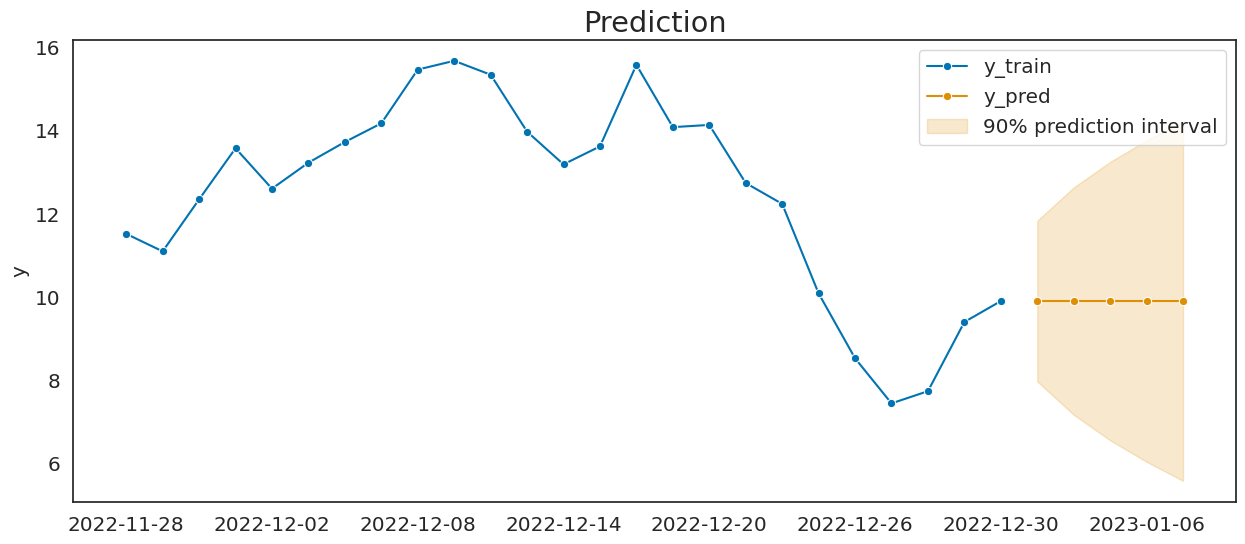

In [25]:
y_pred, y_pred_ints = LF.update(newdata = newdata, refit=False)
LF.plot.plot_prediction(y_pred, y_pred_ints)